## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-07-22 01:51:50.355 | INFO     |  Running on cpu


In [3]:
task = "BlockCabinetPinkGrab"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-07-22 01:51:54.400 | INFO     |  Loading dataset(s): 
2025-07-22 01:51:54.400 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockCabinetPinkGrab/demos/metadata.json
2025-07-22 01:51:54.403 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6, 255]
2025-07-22 01:51:54.403 | INFO     |    Extracted tsdf object labels []
2025-07-22 01:51:54.403 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([247, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([247]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([247, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([247, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([247, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([247, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=1,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
    velocity_threshold=0.0005,
    max_idx_distance=10,
    min_end_distance=20,
    min_len=10,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-07-22 01:52:07.002 | INFO     |  Fitting AutoTPGMM
2025-07-22 01:52:07.002 | INFO     |  Performing fitting actions: [INIT]
2025-07-22 01:52:07.002 | INFO     |  Segmenting trajectories


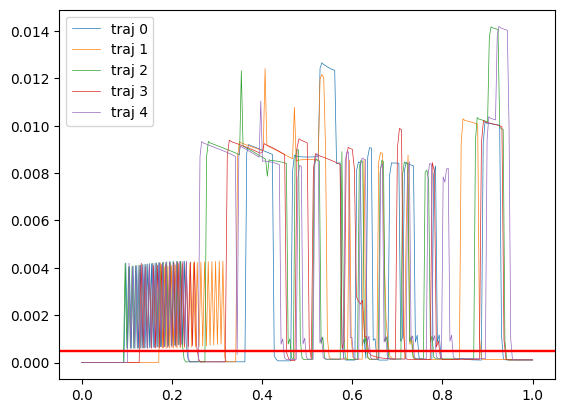

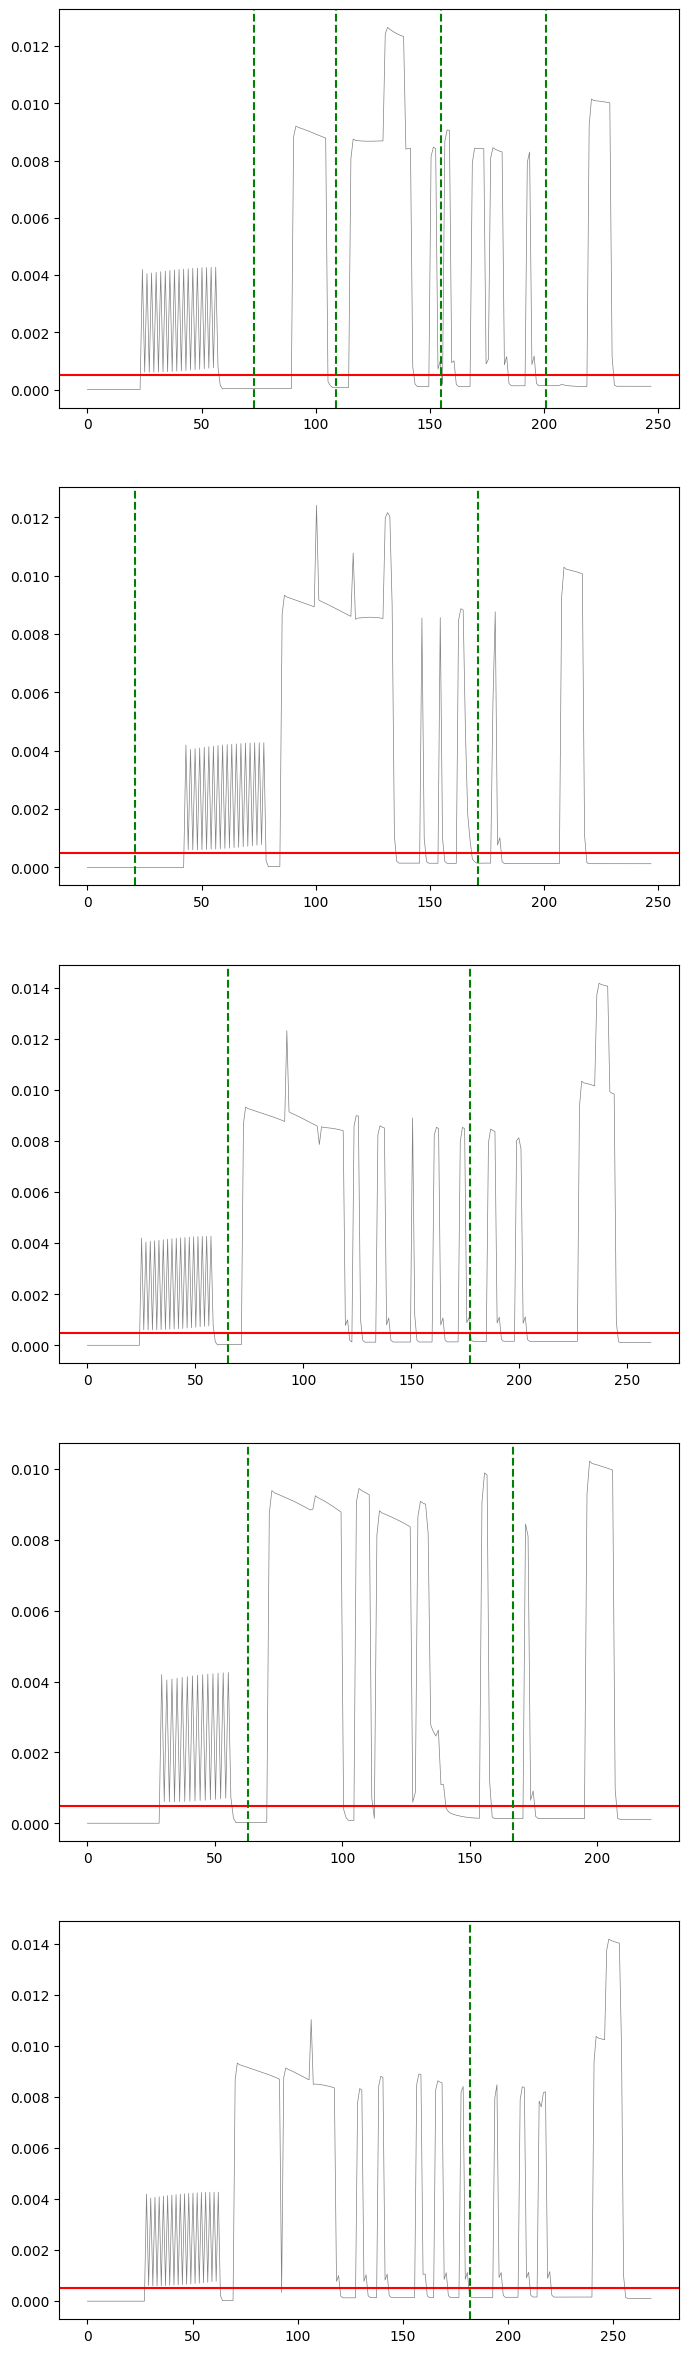

2025-07-22 01:52:07.831 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(109, dtype=torch.int32), tensor(155, dtype=torch.int32), tensor(201, dtype=torch.int32)) from traj 0 of len 247
2025-07-22 01:52:07.832 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(171, dtype=torch.int32),) from traj 1 of len 247
2025-07-22 01:52:07.832 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(177, dtype=torch.int32),) from traj 2 of len 261
2025-07-22 01:52:07.832 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(167, dtype=torch.int32),) from traj 3 of len 221
2025-07-22 01:52:07.832 | INFO     |  Creating segement of demos.
202

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:07.875 | INFO     |    Fitting candidate frame 2/10
2025-07-22 01:52:07.876 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:07.932 | INFO     |    Fitting candidate frame 3/10
2025-07-22 01:52:07.932 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:07.990 | INFO     |    Fitting candidate frame 4/10
2025-07-22 01:52:07.990 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.035 | INFO     |    Fitting candidate frame 5/10
2025-07-22 01:52:08.036 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.138 | INFO     |    Fitting candidate frame 6/10
2025-07-22 01:52:08.139 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.236 | INFO     |    Fitting candidate frame 7/10
2025-07-22 01:52:08.236 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.299 | INFO     |    Fitting candidate frame 8/10
2025-07-22 01:52:08.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.357 | INFO     |    Fitting candidate frame 9/10
2025-07-22 01:52:08.357 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.402 | INFO     |    Fitting candidate frame 10/10
2025-07-22 01:52:08.403 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:08.451 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-07-22 01:52:08.453 | INFO     |  obj006     score (rel):     -0 (0.003)
2025-07-22 01:52:08.453 | INFO     |  obj007     score (rel):     -0 (0.159)
2025-07-22 01:52:08.454 | INFO     |  obj008     score (rel):     -0 (0.009)
2025-07-22 01:52:08.454 | INFO     |  Creating partial frame view of demos.
2025-07-22 01:52:08.519 | INFO     |    Fitting candidate frame 1/10
2025-07-22 01:52:08.520 | INFO     |    Creating partial frame view of demos.
2025-07

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:08.600 | INFO     |    Fitting candidate frame 2/10
2025-07-22 01:52:08.600 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:08.677 | INFO     |    Fitting candidate frame 3/10
2025-07-22 01:52:08.678 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:08.724 | INFO     |    Fitting candidate frame 4/10
2025-07-22 01:52:08.725 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:08.835 | INFO     |    Fitting candidate frame 5/10
2025-07-22 01:52:08.835 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:08.937 | INFO     |    Fitting candidate frame 6/10
2025-07-22 01:52:08.938 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:09.078 | INFO     |    Fitting candidate frame 7/10
2025-07-22 01:52:09.078 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:09.167 | INFO     |    Fitting candidate frame 8/10
2025-07-22 01:52:09.167 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:09.272 | INFO     |    Fitting candidate frame 9/10
2025-07-22 01:52:09.273 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:09.403 | INFO     |    Fitting candidate frame 10/10
2025-07-22 01:52:09.405 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-22 01:52:09.542 | INFO     |  ee_init    score (rel):     -0 (0.322)
2025-07-22 01:52:09.542 | INFO     |  obj000     score (rel):     -0 (0.322)
2025-07-22 01:52:09.542 | INFO     |  obj001     score (rel):     -0 (0.322)
2025-07-22 01:52:09.543 | INFO     |  obj002     score (rel):     -0 (0.322)
2025-07-22 01:52:09.543 | INFO     |  obj003     score (rel):     -0 (0.322)
2025-07-22 01:52:09.543 | INFO     |  obj004     score (rel):     -0 (0.322)
2025-07-22 01:52:09.543 | INFO     |  obj005     score (rel):     -0 (0.322)
2025-07-22 01:52:09.543 | INFO     |  obj006     score (rel):     -0 (0.046)
2025-07-22 01:52:09.543 | INFO     |  obj007     score (rel):     -0 (0.058)
2025-07-22 01:52:09.543 | INFO     |  obj008     score (rel):     -0 (1.000)
2025-07-22 01:52:09.544 | WARNING  |  Selected frames for segments 0 and 1 are disjoint. 
2025-07-22 01:52:09.544 | INFO     |  Adding frame 1 to segment 1.
2025-07-22 01:52:09.545 | INFO     |  Creating partial frame view of demo

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-07-22 01:52:09.689 | INFO     |  Manifold: TIME x R3 x R3 x R3 x R3 x R3 x R3 x R3 x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:52:09.741 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

((array([[2.00e+28, 2.00e+28, 1.94e+28, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.86e+25, 3.10e+25, 3.36e+25, ..., 3.76e+22, 9.97e+21, 1.07e+22],
         [5.62e-19, 7.41e-18, 9.46e-17, ..., 3.97e+25, 4.32e+25, 4.34e+25]]),
  array([[4.27e+005, 4.27e+005, 4.13e+005, ..., 1.43e-190, 6.56e-193,
          2.89e-195],
         [2.04e+004, 2.29e+004, 2.56e+004, ..., 3.28e-025, 1.28e-025,
          4.98e-026],
         [5.21e-006, 7.53e-006, 1.08e-005, ..., 7.66e-014, 3.56e-014,
          1.63e-014],
         [6.48e-027, 1.11e-026, 1.88e-026, ..., 1.43e-005, 1.01e-005,
          6.91e-006],
         [2.73e-102, 2.66e-101, 2.57e-100, ..., 3.49e+005, 2.85e+005,
          2.28e+005],
         [7.40e-217, 1.52e-214, 3.02e-212, ..., 9.38e+006, 9.53e+006,
          9.35e+006]])),
 (-60.06945342413244, -14.37021861879952))

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-07-22 01:52:10.052 | INFO     |  Did not specify time_based, deciding automatically.
2025-07-22 01:52:10.144 | WARNING  |  Skippig NaN Gaussians.


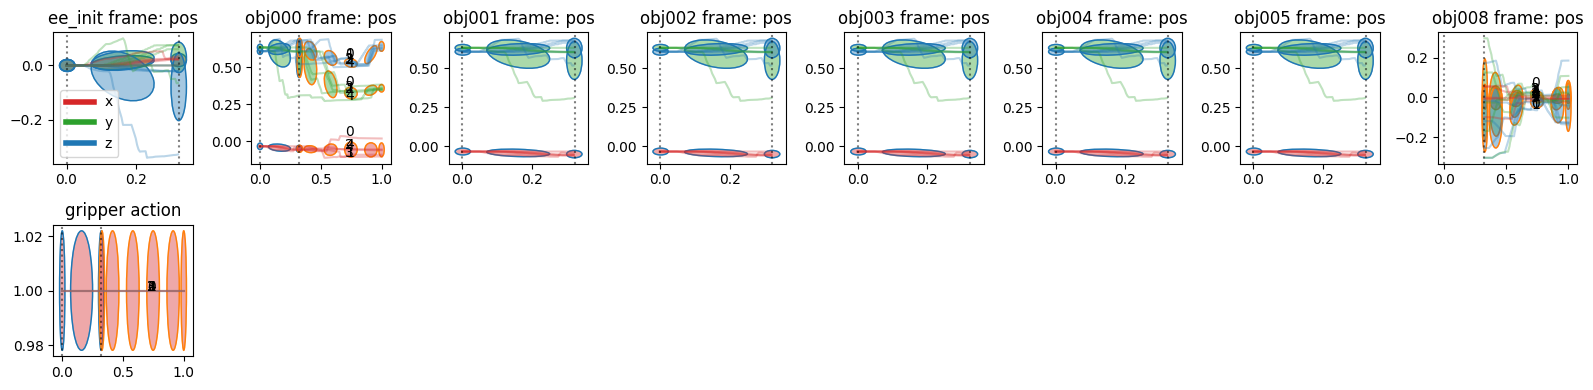

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-07-22 01:52:12.548 | INFO     |  Fitting AutoTPGMM
2025-07-22 01:52:12.549 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-07-22 01:52:12.561 | INFO     |  HMM EM ...
2025-07-22 01:52:12.563 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 01:52:12.579 | INFO     |  HMM init priors not defined, initializing to uniform
2025-07-22 01:52:12.622 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[9.99e-01, 9.98e-01, 9.98e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.42e-03, 1.55e-03, 1.73e-03, ..., 9.46e-04, 2.31e-04, 2.47e-04],
         [2.80e-47, 3.69e-46, 4.87e-45, ..., 9.99e-01, 1.00e+00, 1.00e+00]]),
  array([[9.54e-001, 9.49e-001, 9.42e-001, ..., 1.47e-197, 6.69e-200,
          3.02e-202],
         [4.55e-002, 5.10e-002, 5.84e-002, ..., 3.37e-032, 1.31e-032,
          5.20e-033],
         [1.17e-011, 1.67e-011, 2.46e-011, ..., 7.88e-021, 3.63e-021,
          1.70e-021],
         [1.45e-032, 2.47e-032, 4.30e-032, ..., 1.47e-012, 1.03e-012,
          7.22e-013],
         [6.10e-108, 5.92e-107, 5.85e-106, ..., 3.59e-002, 2.90e-002,
          2.38e-002],
         [1.66e-222, 3.38e-220, 6.88e-218, ..., 9.64e-001, 9.71e-001,
          9.76e-001]])),
 (4805.556273930595, 2414.1967279583196))

2025-07-22 01:52:12.860 | INFO     |  Did not specify time_based, deciding automatically.


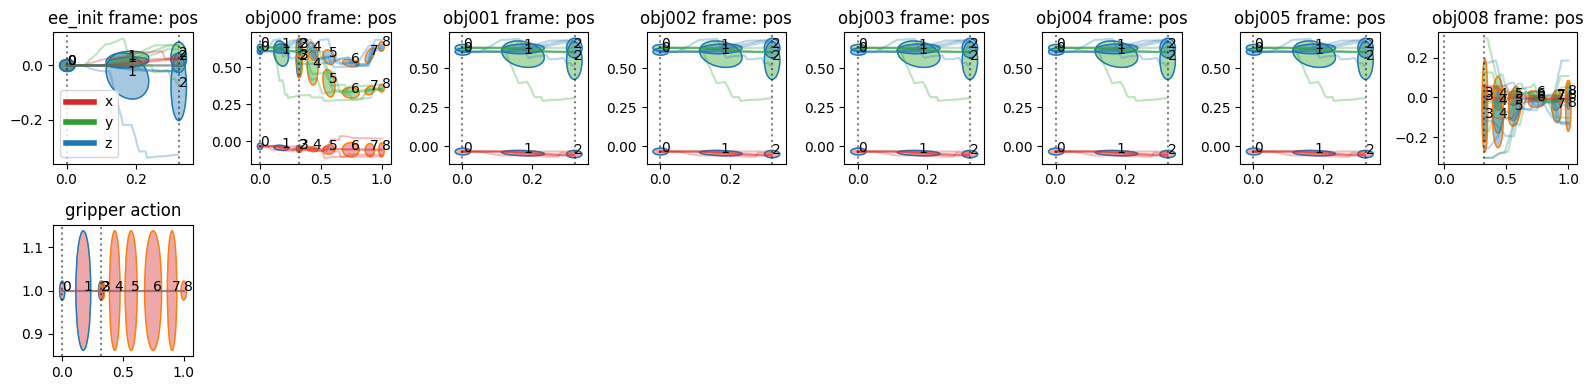

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

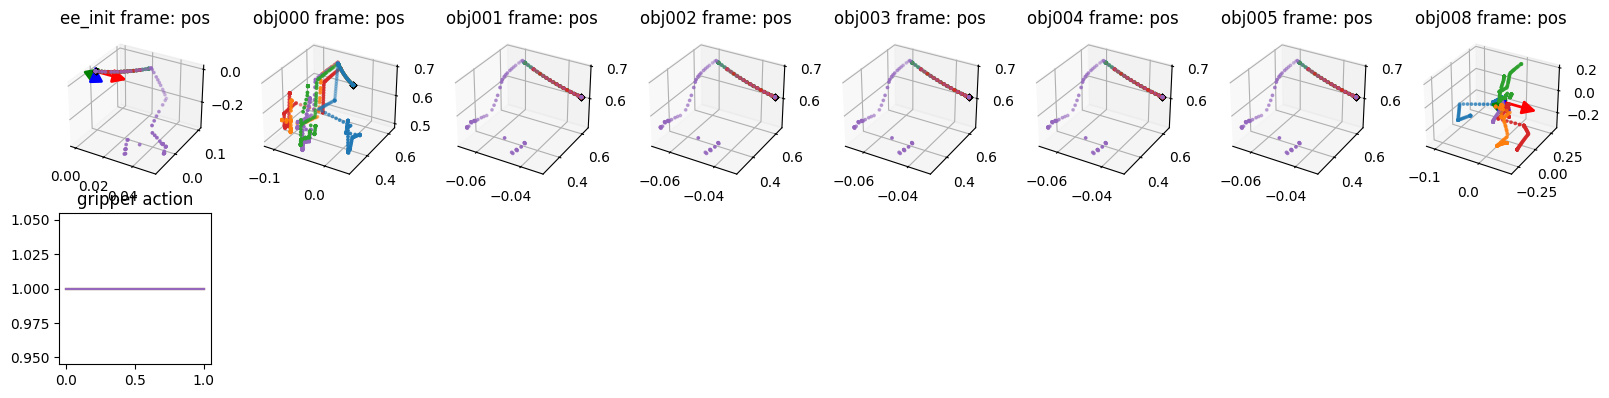

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

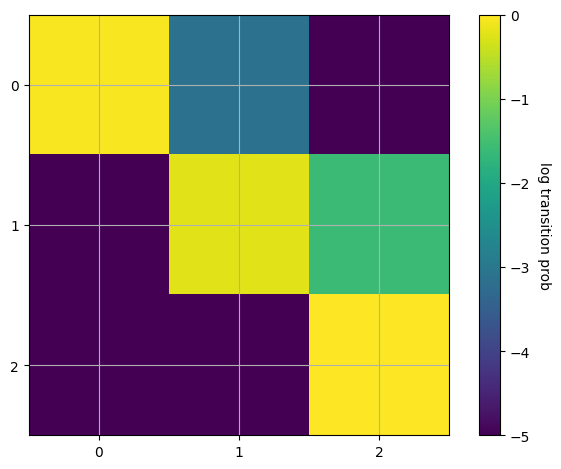

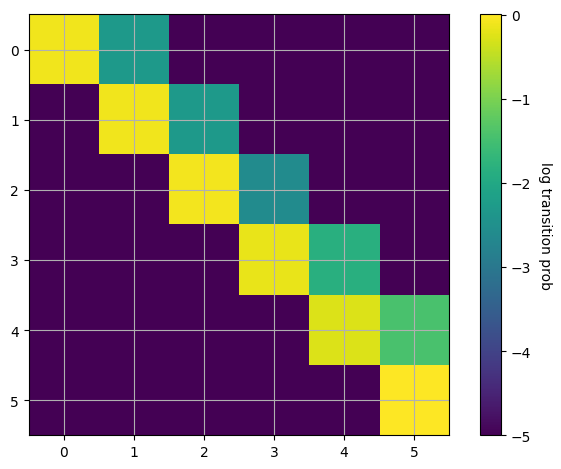

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-07-22 01:52:18.984 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-07-22 01:52:19.146 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-07-22 01:52:19.172 | INFO     |  Caculated segment transition probabilities: (array([[1.]]),)
2025-07-22 01:52:19.173 | INFO     |  Creating partial frame view of demos.
2025-07-22 01:52:19.204 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-22 01:52:19.330 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-22 01:52:19.440 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

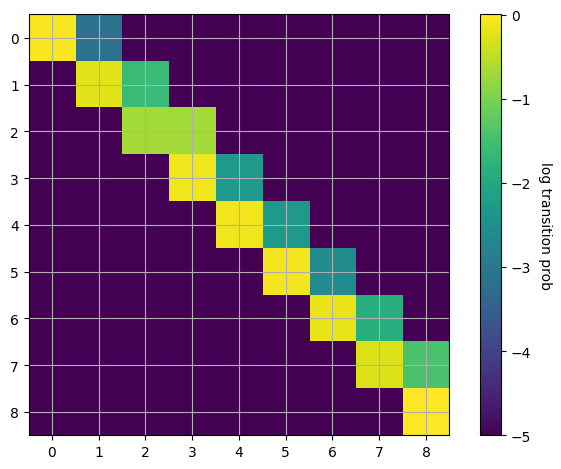

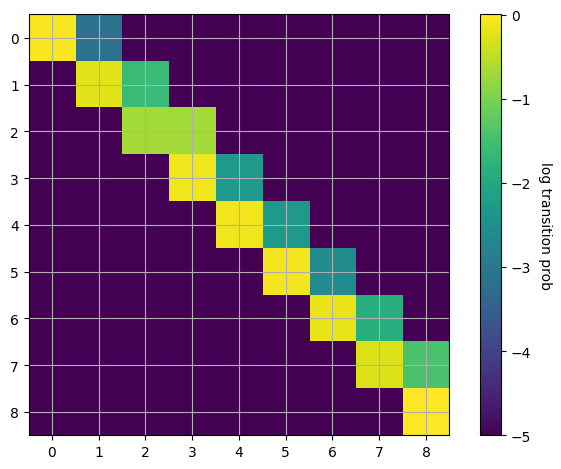

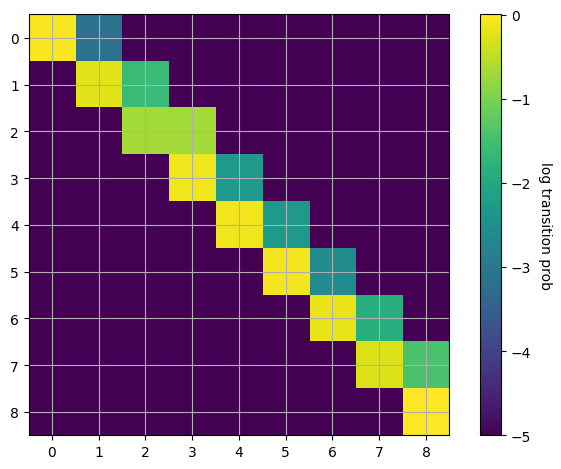

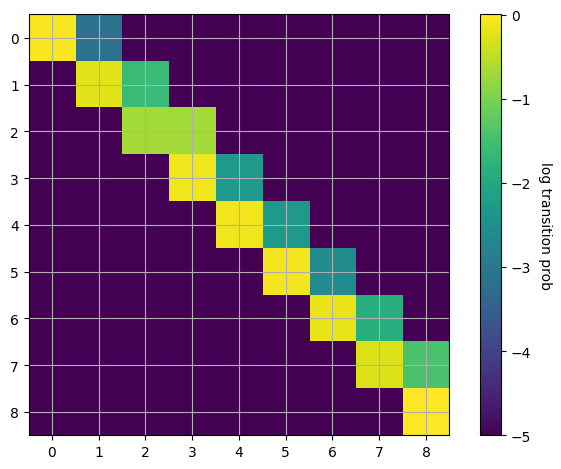

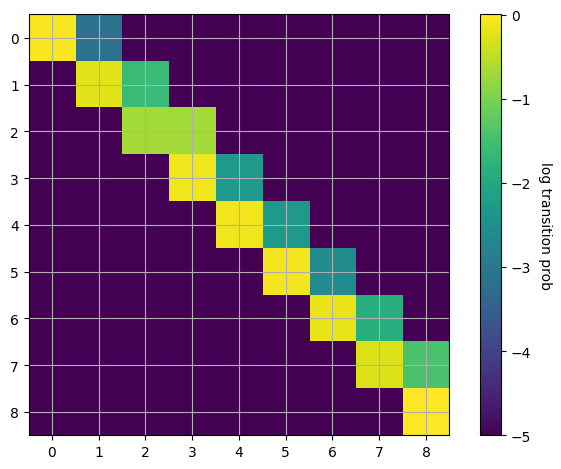

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2025-07-22 01:52:24.218 | INFO     |  Taking frame origins from demos.


KeyboardInterrupt: 

2025-02-09 02:36:23.410 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


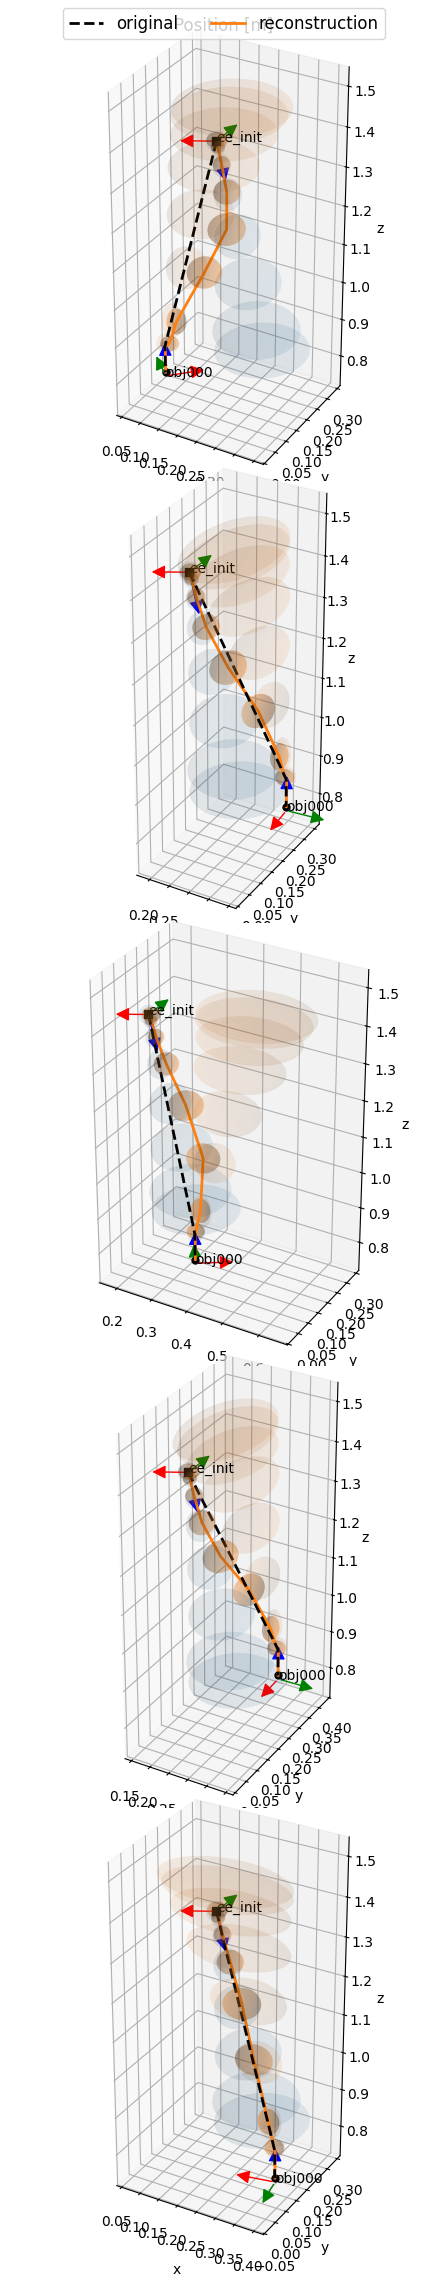

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
